## Score Matching Algorithm

- 어떤 확률분포 $p(x)$를 학습 해보자

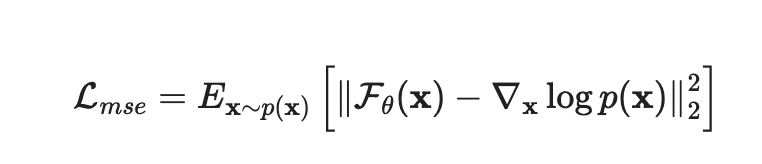

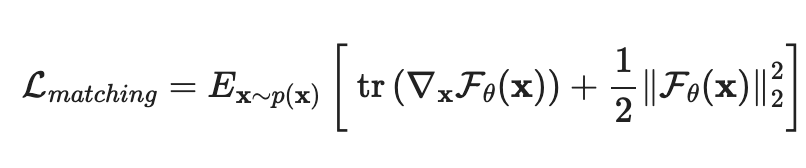

- 확률 분포 $p(x)$를 직접 학습하는 대신 로그 확률의 그래디언트(즉, score  $∇logp(x)$)를 학습하는 것이 목표
- 기존의 intractable 한 loss 식을 tractable로 변환
- 자코비안 행렬의 대각합(trace)과 $L_2 norm$을 최소화하는 방식으로 학습

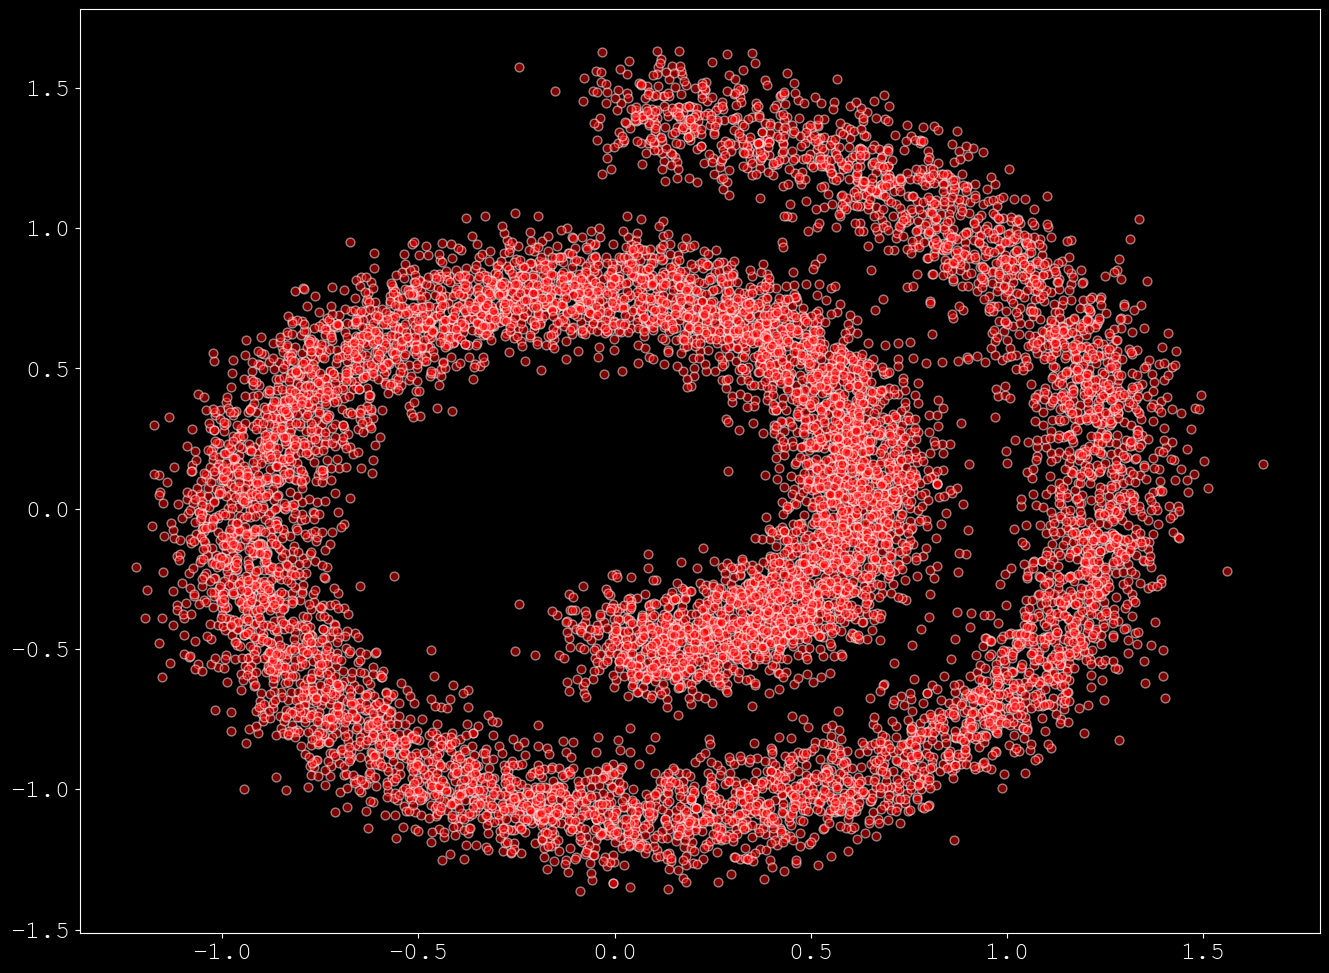

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_swiss_roll
from helper_plot import hdr_plot_style
hdr_plot_style()

def sample_batch(size, noise = 1.0):
    x , _ = make_swiss_roll(size, noise= noise)
    return x[:, [0, 2]] / 10.0
data = sample_batch(10**4).T
plt.figure(figsize=(16, 12))
plt.scatter(*data, alpha=0.5, color='red', edgecolor='white', s=40)

In [16]:
data.shape

(2, 10000)

In [57]:
import torch
import torch.nn as nn
import torch.optim as optim

In [58]:
model = nn.Sequential(
    nn.Linear(2,16), nn.Softplus(),
    # nn.Linear(128,128), nn.Softplus(),
    nn.Linear(16, 2)
)
optimier = optim.Adam(model.parameters(), lr = 1e-3)

In [59]:
import torch.autograd as autograd
def jacobian(f, x):
    B, N = x.shape # x의 크기: (Batch 크기, 입력 변수 개수)
    y = f(x) # y = f(x)를 계산 (출력 크기: B × M)
    # 모델의 출력 y을 입력 x에 대해 미분하여 자코비안 행렬(Jacobian matrix)을 계산하는 과정
    
    jacobian = list()
    for i in range(N):
        v = torch.zeros_like(y)
        v[:, i] = 1.
        dy_i_dx = autograd.grad(y, x, grad_outputs = v, 
                                retain_graph = True, create_graph = True,
                                allow_unused=True)[0] # 모델의 출력과 입력값을 비교함
        jacobian.append(dy_i_dx)
    jacobian = torch.stack(jacobian, dim = 2).requires_grad_()
    return jacobian

In [60]:
def score_matching(model, samples, train = False):
    """
    sample: dataset
    """
    
    samples.requires_grad_(True)
    logp = model(samples) # 로그 확률 밀도 함수의 값을 예측.

    # compute the norm loss
    norm_loss = torch.norm(logp, dim = -1) ** 2 / 2.

    # compute the Jacobian loss
    jacob_mat = jacobian(model, samples)
    tr_jacobian_loss = torch.diagonal(jacob_mat, dim1 = -2, dim2 = -1).sum(-1) # 자코비안 행렬의 대각합
    # dim1: 행(row) 차원
    # dim2: 열(column) 차원
    return (tr_jacobian_loss + norm_loss).mean(-1) # 마지막 차원의 평균을 구함 -> 각 샘플의 평균

In [61]:
dataset = torch.tensor(data.T).float()
for t in range(2000):
    loss = score_matching(model, dataset)

    optimier.zero_grad()

    loss.backward()

    optimier.step()

    if ((t% 500) == 0):
        print(loss)

tensor(-0.1028, grad_fn=<MeanBackward1>)
tensor(-2.1620, grad_fn=<MeanBackward1>)
tensor(-2.2103, grad_fn=<MeanBackward1>)
tensor(-2.3051, grad_fn=<MeanBackward1>)


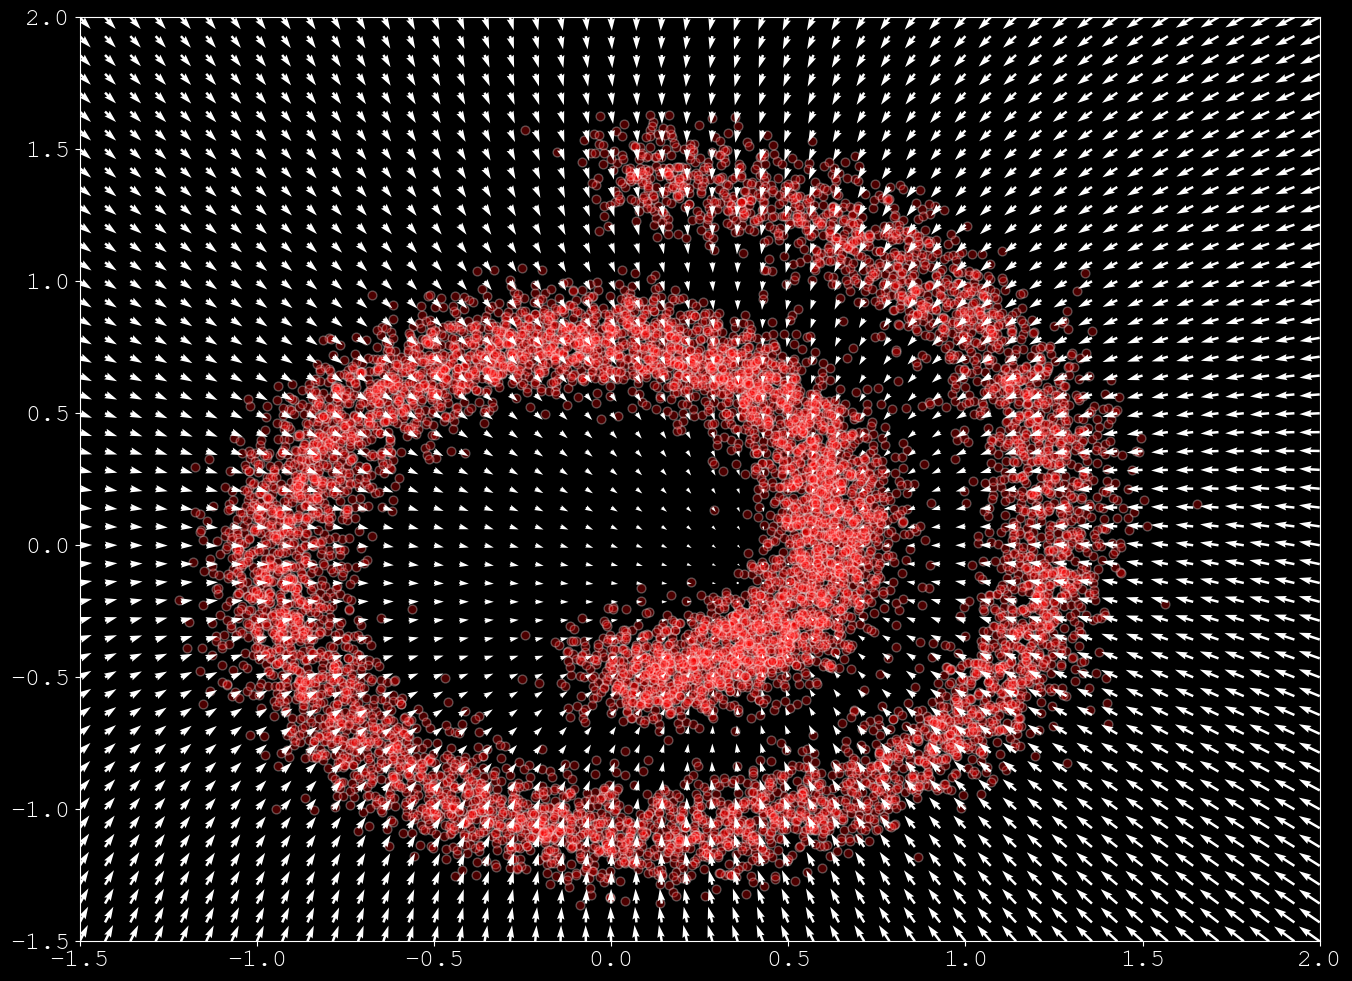

In [62]:
def plot_gradients(model, data, plot_scatter=True):
    xx = np.stack(np.meshgrid(np.linspace(-1.5, 2.0, 50), np.linspace(-1.5, 2.0, 50)), axis=-1).reshape(-1, 2)
    scores = model(torch.tensor(xx).float()).detach()
    scores_norm = np.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
    scores_log1p = scores / (scores_norm + 1e-9) * np.log1p(scores_norm)
    # Perform the plots
    plt.figure(figsize=(16,12))
    if (plot_scatter):
        plt.scatter(*data, alpha=0.3, color='red', edgecolor='white', s=40)
    plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color='white')
    plt.xlim(-1.5, 2.0)
    plt.ylim(-1.5, 2.0)
plot_gradients(model, data)

## Langevin dynamics

- 모델이 학습된 후에는 **확률 밀도의 그래디언트(Score Function)를 근사할 수 있음**.  ($\mathcal{F}_\theta(\mathbf{x}) \approx \nabla_x \log p(\mathbf{x}).$)
- 즉, 모델 ($\mathcal{F}_\theta(\mathbf{x}) $)는 ( $\nabla_x \log p(\mathbf{x}) $) (로그 확률 밀도의 그래디언트)를 학습하게 됨.

---



- $ \mathbf{x}_0 \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$ 이를 이용해 **새로운 데이터를 생성할 수 있음**.  
- **Gradient Ascent (경사 상승법)** 을 사용하여 확률 분포의 지역 최댓값을 찾음.  
- 초기 샘플 $ \mathbf{x}_0 $는 **정규분포 $ \mathcal{N}(\mathbf{0}, \mathbf{I}) $에서 샘플링됨**.  
- 그런 다음, **로그 확률의 그래디언트 정보를 이용하여 $ p(\mathbf{x}) $의 지역 최댓값을 찾아감**.

---

$$
\mathbf{x}_{t+1} = \mathbf{x}_t + \epsilon \nabla_{\mathbf{x}_t} \log p(\mathbf{x}_t)
$$

- **Langevin Dynamics 업데이트 공식**  
- 현재 샘플 $\mathbf{x}_t$에서 **로그 확률의 그래디언트 방향으로 이동**  
- $\epsilon$은 **스텝 크기(step size), 즉 학습률(learning rate)에 해당하는 역할**.
- 여기서 $\epsilon$은 **그래디언트 방향으로 이동하는 스텝 크기**를 결정함.  
- 이는 **딥러닝에서 학습률(learning rate)과 유사한 개념**.

---

In [ ]:
def sample_simple(model, x, n_steps=20, eps=1e-3):
    x_sequence = [x.unsqueeze(0)]
    for s in range(n_steps):
        x = x + eps * model(x) # gradient ascent
        x_sequence.append(x.unsqueeze(0))
    return torch.cat(x_sequence)

x = torch.Tensor([1.5, -1.5])
samples = sample_simple(model, x).detach()
plot_gradients(model, data)
plt.scatter(samples[:, 0], samples[:, 1], color='green', edgecolor='white', s=150)
# draw arrows for each  step
deltas = (samples[1:] - samples[:-1])
deltas = deltas - deltas / np.linalg.norm(deltas, keepdims=True, axis=-1) * 0.04
for i, arrow in enumerate(deltas):
    plt.arrow(samples[i,0], samples[i,1], arrow[0], arrow[1], width=1e-4, head_widt